In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import corner
import pocomc as pc
import pymc as pm
import mistsim as ms

In [2]:
NBINS = 1

### Load data

['ant_temp', 'freq', 'lst']


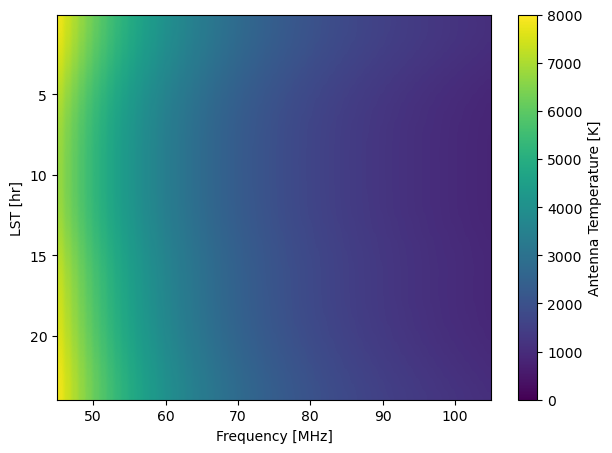

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Global signal

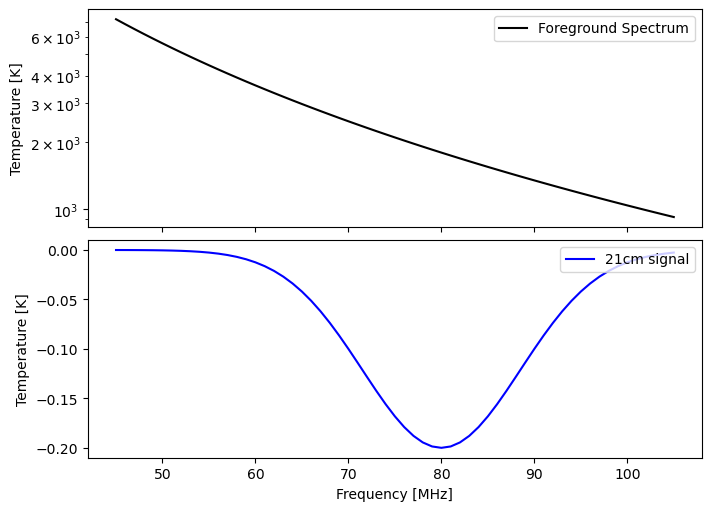

In [4]:
TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = ms.utils.gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

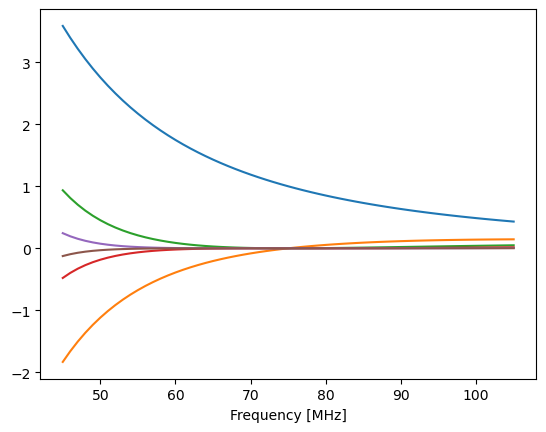

In [5]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [6]:
cut = nspec % NBINS
total_temp = temp + TRUE_T21

if cut == 0:
    binned = total_temp.copy()
else:
    binned = total_temp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)


tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = total_temp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

In [7]:
NFG = [6]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i]) for i in range(NBINS)]

### Run pocomc

In [9]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler("pocomc", bounds, lst_bins)

Iter: 56it [06:13,  6.67s/it, calls=26500, beta=1, logZ=-31.5, ESS=5.05e+3, acc=0.902, steps=2, logP=-27.7, eff=0.72]    


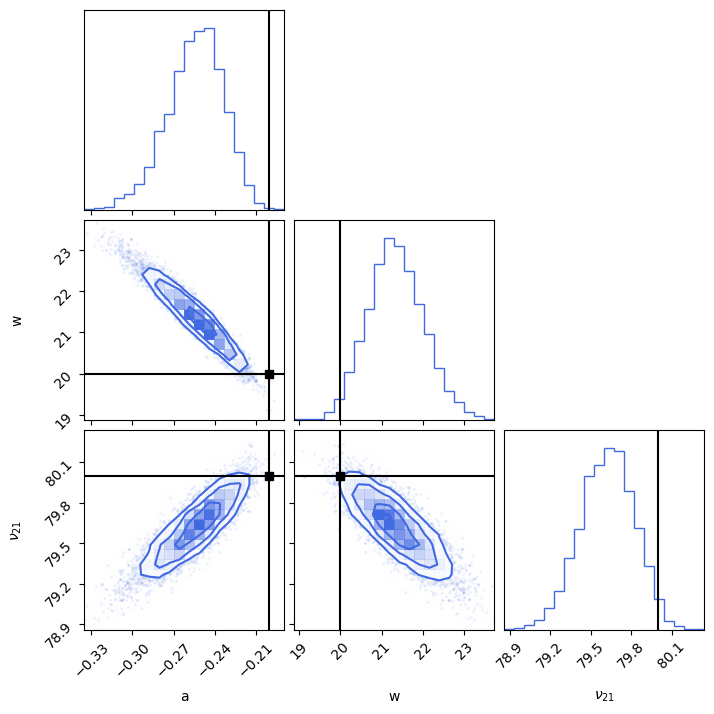

In [10]:
labels = ["a", "w", "$\\nu_{21}$"]
fig = corner.corner(results["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [11]:
estimated_params = results["theta_map"]
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.25409625 21.35095813 79.62404822]
Standard deviation values =  [0.02050981 0.67103691 0.20160668]

[21.2896692   6.3273888   0.47215858]
[2.63757905 2.01323969 1.8647784 ]


# Chromaticity correction

In [8]:
path = "CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5"
acp = path.replace(".hdf5", "_achromatic_75MHz.hdf5")
acp

'CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5'

['ant_temp', 'freq', 'lst']


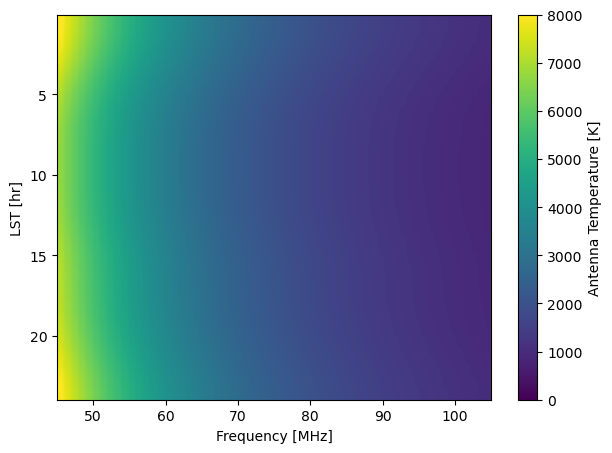

In [9]:
ac_temp = ms.utils.read_hdf5_convolution(f"../simulations/{acp}", print_key=True)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

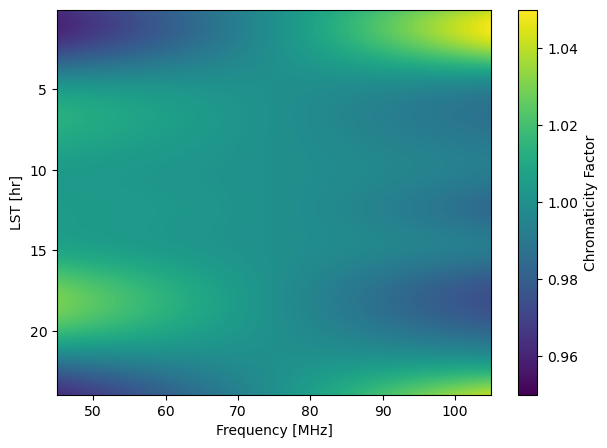

In [10]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [11]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
    chrom = chrom[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

False
(1, 61)


In [12]:
print(noise.shape)
print(sigma_inv.shape)
print(chrom_mean.shape)

(1, 61)
(1, 61)
(1, 61)


In [13]:
NFG = [5]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [18]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler("pocomc", bounds, lst_bins)

Iter: 15it [00:33,  2.98s/it, calls=3750, beta=0.00206, logZ=-4.03, ESS=1e+3, acc=0.673, steps=1, logP=-807, eff=0.72]       /home/christian/miniconda3/envs/mistsim/lib/python3.11/site-packages/pocomc/scaler.py:269: RuntimeWarning: divide by zero encountered in log
  log_det_J = np.log(np.prod(J, axis=1))
Iter: 59it [06:47,  6.90s/it, calls=24750, beta=1, logZ=-34.6, ESS=4.87e+3, acc=0.915, steps=1, logP=-29.3, eff=0.72]     


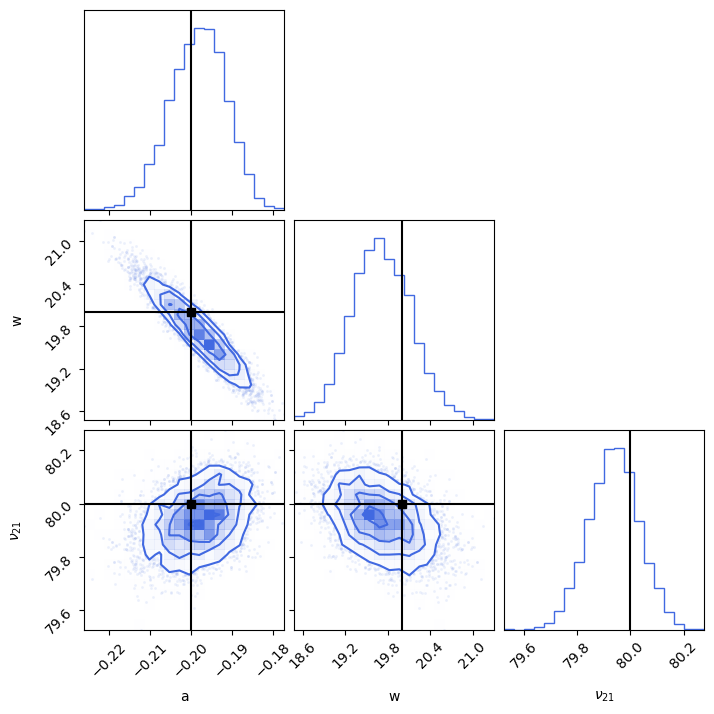

In [19]:
fig = corner.corner(results["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [20]:
estimated_params = results["theta_map"]
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.19832657 19.71755042 79.94030328]
Standard deviation values =  [0.00679953 0.41553546 0.0942094 ]

[0.84377741 1.43247804 0.07467663]
[0.2461104  0.67972437 0.63365993]


### Run PyMC

In [31]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
idata = ms.run_sampler("pymc", bounds, lst_bins[0], draws=5000, tune=2000, nuts={'target_accept':0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a21, w21, nu21]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 36 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a21,-0.20,0.01,-0.21,-0.19,0.00,0.0,5707.84,6784.38,1.0
w21,19.72,0.41,18.96,20.48,0.01,0.0,5649.21,6220.03,1.0
nu21,79.94,0.09,79.76,80.11,0.00,0.0,7545.17,7821.48,1.0
mu[0],7207.45,0.00,7207.45,7207.46,0.00,0.0,7877.65,9870.05,1.0
mu[1],6840.64,0.00,6840.64,6840.64,0.00,0.0,8193.14,10732.74,1.0
...,...,...,...,...,...,...,...,...,...
mu[56],1013.75,0.00,1013.75,1013.75,0.00,0.0,6627.95,7763.80,1.0
mu[57],989.33,0.00,989.33,989.33,0.00,0.0,8423.25,10945.80,1.0
mu[58],965.71,0.00,965.71,965.71,0.00,0.0,18340.36,13620.75,1.0
mu[59],942.86,0.00,942.86,942.86,0.00,0.0,8760.19,10926.11,1.0


In [115]:
keys = ["a21", "w21", "nu21"]
estimated_params = [idata.posterior[k].mean().values[()] for k in keys]
std_vals = [idata.posterior[k].std().values[()] for k in keys]
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)


Mean values =  [-0.19834372387528132, 19.718620386927654, 79.94059419323801]
Standard deviation values =  [0.006722604537592289, 0.4074864750867343, 0.0923112468464644]

[0.83505346 1.42697414 0.07431244]
[0.24637417 0.69052504 0.64353813]


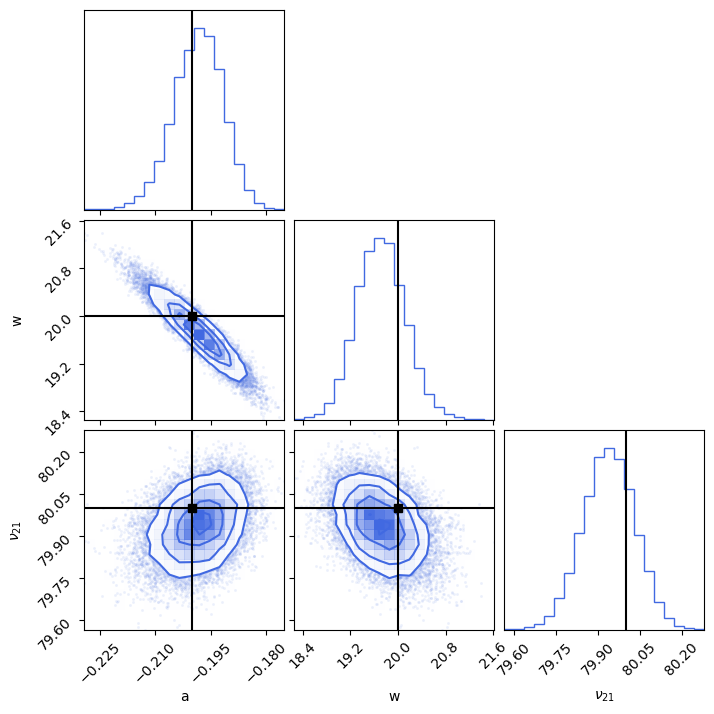

In [69]:
labels = ["a", "w", "$\\nu_{21}$"]
fig = corner.corner(idata, var_names=["a21", "w21", "nu21"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [116]:
#az.summary(idata, round_to=2)

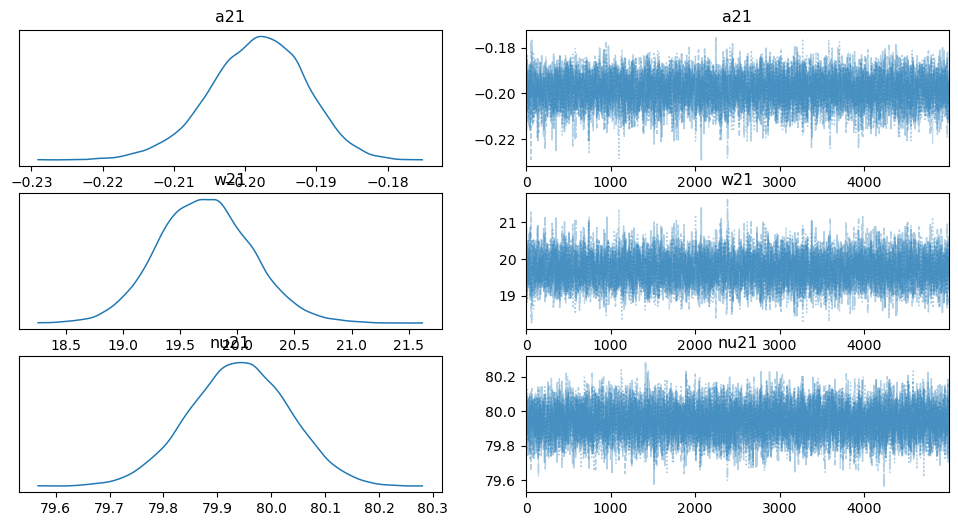

In [34]:
az.plot_trace(idata, combined=True, var_names=["a21", "w21", "nu21"]);

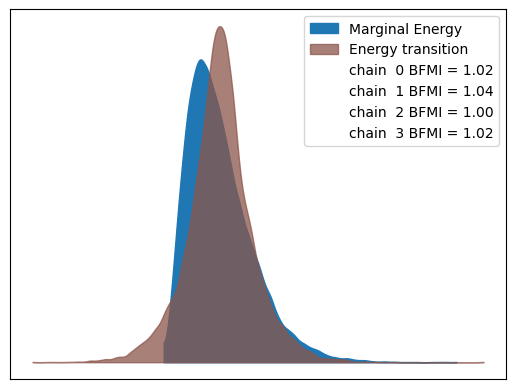

In [33]:
az.plot_energy(idata);

array([<Axes: title={'center': 'a21'}>, <Axes: title={'center': 'w21'}>,
       <Axes: title={'center': 'nu21'}>], dtype=object)

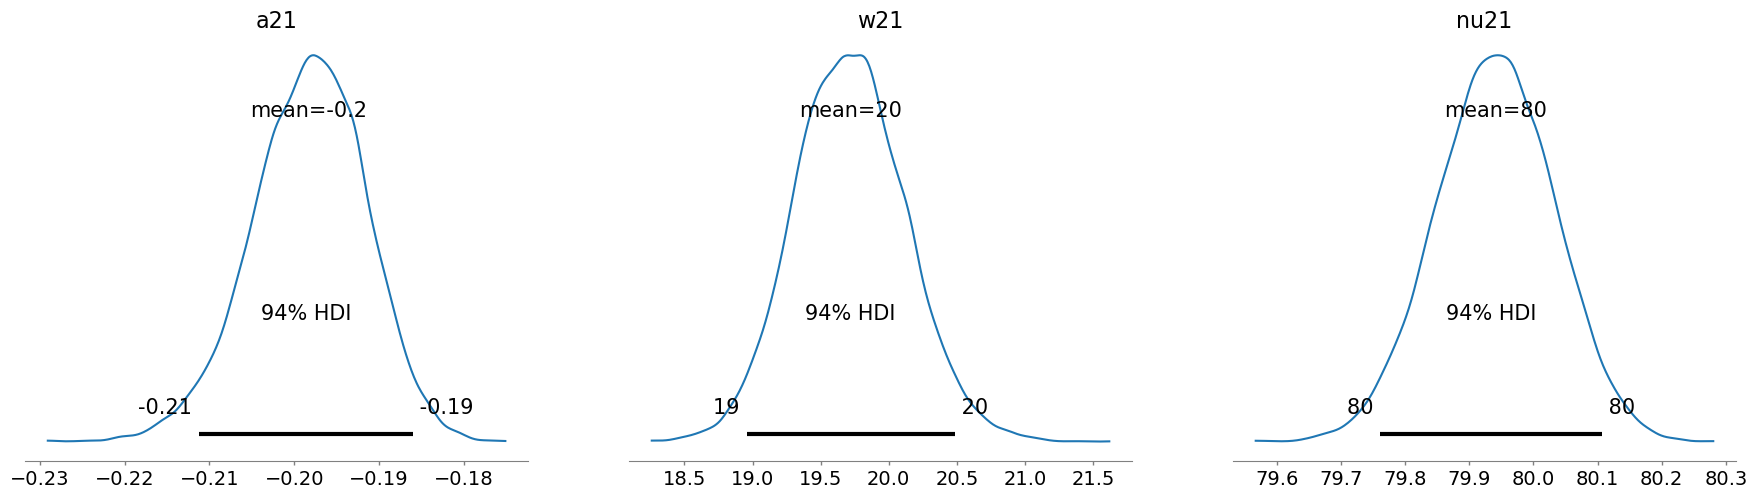

In [64]:
az.plot_posterior(idata, var_names=["a21", "w21", "nu21"])